# Deep Learning -BiLSTM

In [1]:
import os
import pandas as pd
import re
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from gensim.models import KeyedVectors
from gensim.downloader import load as gensim_load
from sklearn.metrics import confusion_matrix, classification_report
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaiki\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kaiki\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Load the dataset
df = pd.read_csv("D3.csv")

In [3]:
# Drop the unnecessary column if it exists
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
# Drop rows with missing values
df.dropna(inplace=True)
print("\nShape after dropping missing values:", df.shape)


Shape after dropping missing values: (28484, 2)


In [5]:
# Check the distribution of 'status' before resampling
print("\nStatus Value Counts before resampling:")
print(df['status'].value_counts())



Status Value Counts before resampling:
status
EDAnonymous      6947
adhd             5110
autism           4576
ptsd             4483
schizophrenia    4281
alcoholism       3087
Name: count, dtype: int64


In [6]:
#  Resampling to Balance Classes
def resample_data(df):
    max_count = df['status'].value_counts().max()
    df_resampled = pd.DataFrame()
    for status in df['status'].unique():
        df_class = df[df['status'] == status]
        if len(df_class) < max_count:
            df_class_resampled = resample(df_class, replace=True, n_samples=max_count, random_state=42)
            df_resampled = pd.concat([df_resampled, df_class_resampled])
        else:
            df_resampled = pd.concat([df_resampled, df_class])
    return df_resampled

df = resample_data(df)
print("Value counts after resampling:")
print(df['status'].value_counts())

Value counts after resampling:
status
adhd             6947
alcoholism       6947
autism           6947
EDAnonymous      6947
ptsd             6947
schizophrenia    6947
Name: count, dtype: int64


In [9]:
# Text Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text.lower())
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['post'] = df['post'].apply(preprocess_text)
print("\nSample preprocessed text:")
print(df['post'].head())


Sample preprocessed text:
860     found psych misdiagnosed adhd child psych clin...
3772    started strattera experience starting stratter...
3092    kvk tech dextroamphetamine quality concern hey...
466     mydayis nausea week one 70mg vyvanse everyday ...
4426    diagnosed add 28 history emotional abuse child...
Name: post, dtype: object


In [10]:
# Splitting Data and Encoding Labels
X = df['post'].values
y = df['status'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (33345,) (33345, 6)
Testing set shape: (8337,) (8337, 6)


In [11]:
# Tokenization and Padding
max_words = 50000
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_sequence_length = 100
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post', truncating='post')
print("Padded Training Data Shape:", X_train_padded.shape)
print("Padded Testing Data Shape:", X_test_padded.shape)

Padded Training Data Shape: (33345, 100)
Padded Testing Data Shape: (8337, 100)


In [12]:
# Loading Pre-trained Word2Vec via Gensim Downloader
print("Downloading the pre-trained Google News Word2Vec model. This may take a while...")
word2vec_model = gensim_load("word2vec-google-news-300")
embedding_dim = word2vec_model.vector_size  
print("Download complete. Embedding dimension:", embedding_dim)

Download complete. Embedding dimension: 300


In [13]:
# Building the Embedding Matrix with Fine-Tuning Enabled
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
found_count = 0

for word, i in word_index.items():
    if i >= max_words:
        continue
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]
        found_count += 1
    else:
        # Initialize missing words with random vectors
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

print(f"Found embeddings for {found_count} out of {num_words} words.")

Found embeddings for 26196 out of 44840 words.


In [14]:
# Building the BiLSTM Model (with Fine-Tuning)
lstm_units = 64
num_classes = y_categorical.shape[1]

model = Sequential([
    Embedding(input_dim=num_words, 
              output_dim=embedding_dim, 
              input_length=max_sequence_length,
              weights=[embedding_matrix],
              trainable=True),  # Now set to True for fine-tuning
    Bidirectional(LSTM(units=lstm_units, dropout=0.2, recurrent_dropout=0.2)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

C:\Users\kaiki\Documents\anaconda\envs\tensorflow_env\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │      13,452,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,452,000 (51.32 MB)

 Trainable params: 13,452,000 (51.32 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Training the Model
history = model.fit(X_train_padded, y_train,
                    epochs=10,           
                    batch_size=128,      
                    validation_data=(X_test_padded, y_test))

Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 87s 317ms/step - accuracy: 0.5713 - loss: 1.1626 - val_accuracy: 0.9025 - val_loss: 0.3224
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 642s 2s/step - accuracy: 0.9105 - loss: 0.3054 - val_accuracy: 0.9314 - val_loss: 0.2340
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 73s 279ms/step - accuracy: 0.9540 - loss: 0.1654 - val_accuracy: 0.9429 - val_loss: 0.2181
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 73s 281ms/step - accuracy: 0.9703 - loss: 0.1107 - val_accuracy: 0.9494 - val_loss: 0.2001
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 72s 275ms/step - accuracy: 0.9761 - loss: 0.0890 - val_accuracy: 0.9554 - val_loss: 0.1809
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 72s 275ms/step - accuracy: 0.9870 - loss: 0.0517 - val_accuracy: 0.9543 - val_loss: 0.2058
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 70s 269ms/step - accuracy: 0.9922 - loss: 0.0369 - val_accuracy: 0.9562 - val_loss: 0.1930
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 70s 268ms/step - accuracy: 0.9921 - loss: 0.0

In [16]:
# Evaluating the Model
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print("\nTest Accuracy: {:.2f}%".format(test_accuracy * 100))


261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9601 - loss: 0.2148

Test Accuracy: 95.78%


261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
Confusion Matrix:
[[1313   21    9   14   32   12]
 [  12 1392    3   31   21   10]
 [   9    0 1338    4    9    1]
 [  10    6    1 1311   24    7]
 [   7    4    3    9 1330    9]
 [  11   13    9   13   38 1301]]


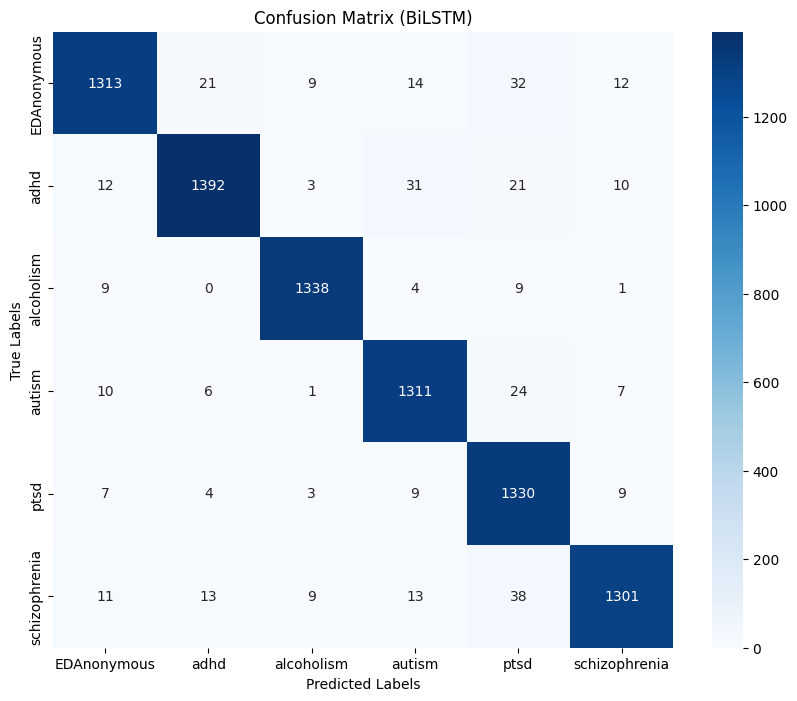

Classification Report:
               precision    recall  f1-score   support

  EDAnonymous     0.9640    0.9372    0.9504      1401
         adhd     0.9694    0.9476    0.9583      1469
   alcoholism     0.9817    0.9831    0.9824      1361
       autism     0.9486    0.9647    0.9566      1359
         ptsd     0.9147    0.9765    0.9446      1362
schizophrenia     0.9709    0.9394    0.9549      1385

     accuracy                         0.9578      8337
    macro avg     0.9582    0.9581    0.9579      8337
 weighted avg     0.9584    0.9578    0.9578      8337



In [17]:
# Generating Predictions and Evaluation Metrics
y_pred_probs = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (BiLSTM)')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, digits=4))

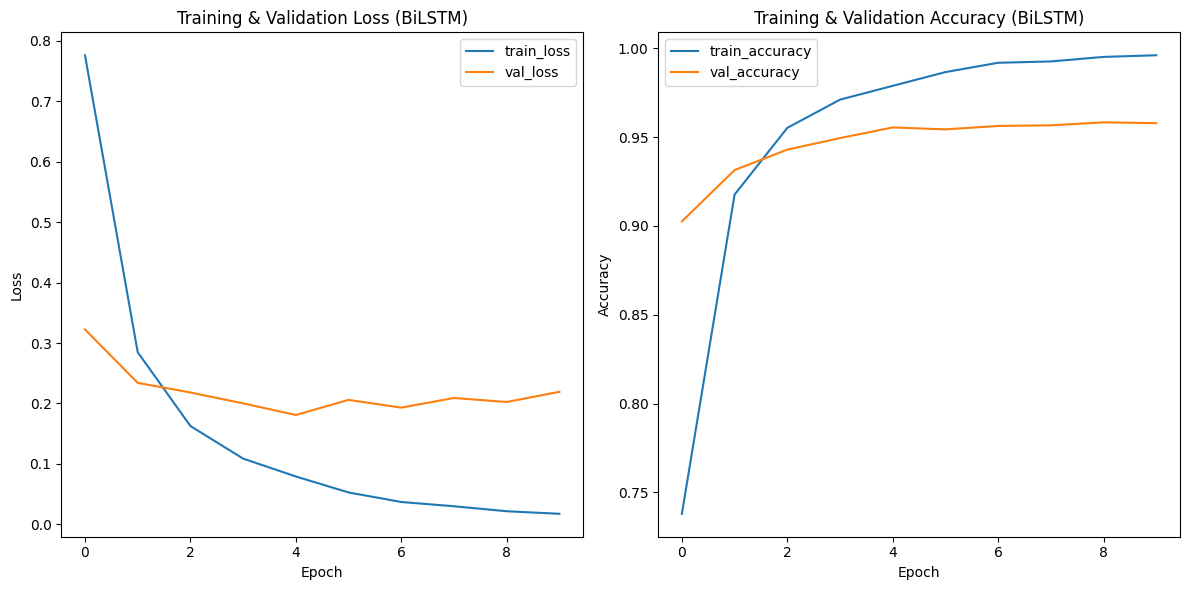

In [18]:
# Plot training & validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training & Validation Loss (BiLSTM)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training & Validation Accuracy (BiLSTM)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

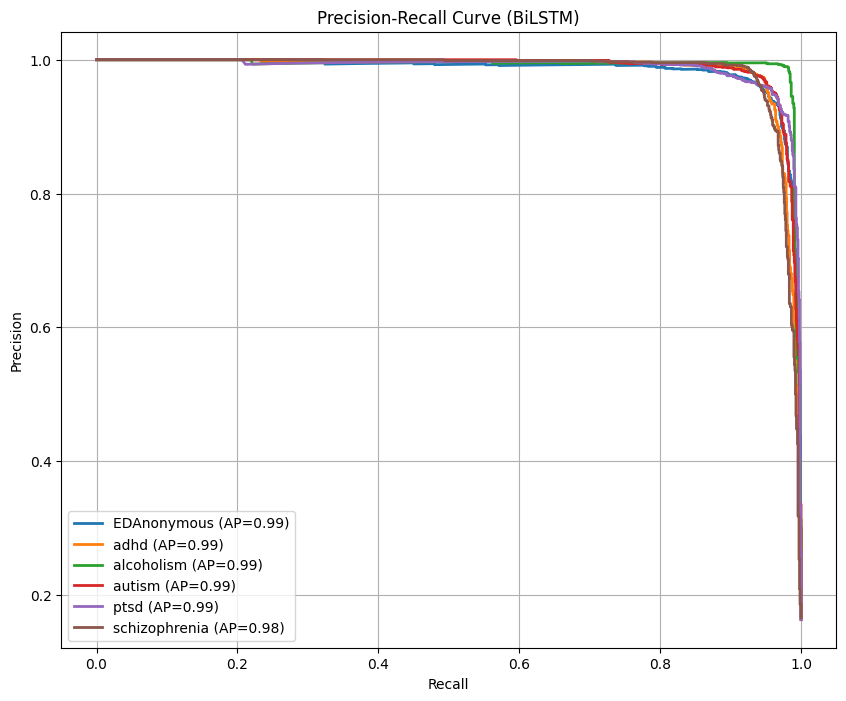

In [19]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Binarize true labels for multi-class PR curve
y_test_bin = label_binarize(y_true, classes=np.arange(num_classes))
precision = dict()
recall = dict()
avg_precision = dict()

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_pred_probs[:, i])
    avg_precision[i] = average_precision_score(y_test_bin[:, i], y_pred_probs[:, i])
    plt.plot(recall[i], precision[i], lw=2, label=f'{label_encoder.classes_[i]} (AP={avg_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (BiLSTM)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


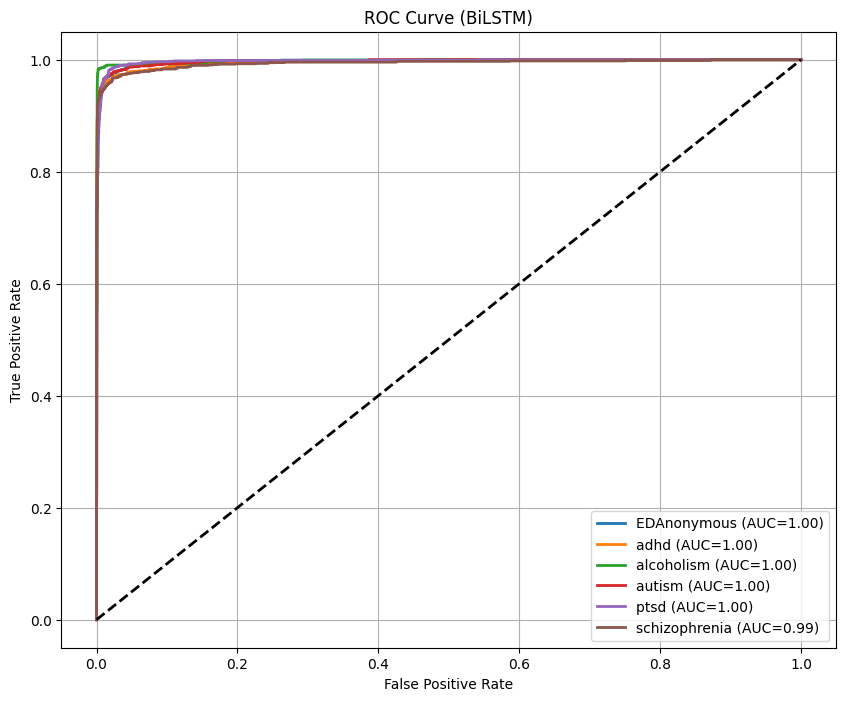

In [20]:
# ROC Curve
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{label_encoder.classes_[i]} (AUC={roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (BiLSTM)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

